# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re


import pickle
from tqdm import tqdm
import os
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df2  = pd.read_csv('/content/drive/MyDrive/Copy of preprocessed_data.csv',nrows=50000) 

In [7]:
df2.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [5]:
y = df2['project_is_approved'].values
X = df2.drop(['project_is_approved'], axis=1)
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,stratify=y)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,train_size=0.8,stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [9]:
l=[]

In [10]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train['essay'].values)
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)
l.extend(vectorizer.get_feature_names())

In [12]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['essay'].values)
X_train_essay_Tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_Tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_Tfidf = vectorizer.transform(X_test['essay'].values)


In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)
X_train_state_clean_categories=vectorizer.transform(X_train['clean_categories'].values)
X_cv_state_clean_categories=vectorizer.transform(X_cv['clean_categories'].values)
X_test_state_clean_categories=vectorizer.transform(X_test['clean_categories'].values)
l.extend(vectorizer.get_feature_names())

In [15]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_categories'].values)
X_train_state_clean_categories_Tfidf=vectorizer.transform(X_train['clean_categories'].values)
X_cv_state_clean_categories_Tfidf=vectorizer.transform(X_cv['clean_categories'].values)
X_test_state_clean_categories_Tfidf=vectorizer.transform(X_test['clean_categories'].values)


In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)
X_train_state_clean_subcategories= vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_state_clean_subcategories= vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_state_clean_subcategories= vectorizer.transform(X_test['clean_subcategories'].values)
l.extend(vectorizer.get_feature_names())

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)
X_train_state_clean_subcategories_Tfidf= vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_state_clean_subcategories_Tfidf= vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_state_clean_subcategories_Tfidf= vectorizer.transform(X_test['clean_subcategories'].values)

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)
l.extend(vectorizer.get_feature_names())

In [19]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 
X_train_teacher_ohe_Tfidf= vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe_Tfidf = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe_Tfidf = vectorizer.transform(X_test['teacher_prefix'].values)


In [20]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)
l.extend(vectorizer.get_feature_names())

In [21]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)
X_train_grade_ohe_Tfidf = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe_Tfidf = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe_Tfidf = vectorizer.transform(X_test['project_grade_category'].values)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [22]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).flatten()
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1)).flatten()
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).flatten()
l.append('price')


In [23]:
X_train_price_norm=X_train_price_norm.reshape(X_train_price_norm.shape[0],1)
X_cv_price_norm=X_cv_price_norm.reshape(X_cv_price_norm.shape[0],1)
X_test_price_norm=X_test_price_norm.reshape(X_test_price_norm.shape[0],1)

In [24]:
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)


(32000, 1) (32000,)
(8000, 1) (8000,)
(10000, 1) (10000,)


In [25]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).flatten()
X_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).flatten()
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).flatten()
l.append('teacher_number_of_previously_posted_projects')

In [26]:
X_train_teacher_number_of_previously_posted_projects_norm=X_train_teacher_number_of_previously_posted_projects_norm.reshape(X_train_teacher_number_of_previously_posted_projects_norm.shape[0],1)
X_cv_teacher_number_of_previously_posted_projects_norm=X_cv_teacher_number_of_previously_posted_projects_norm.reshape(X_cv_teacher_number_of_previously_posted_projects_norm.shape[0],1)
X_test_teacher_number_of_previously_posted_projects_norm=X_test_teacher_number_of_previously_posted_projects_norm.reshape(X_test_teacher_number_of_previously_posted_projects_norm.shape[0],1)

In [27]:
import scipy
X_test_teacher_number_of_previously_posted_projects_norm=scipy.sparse.csr_matrix(X_test_teacher_number_of_previously_posted_projects_norm)
X_cv_teacher_number_of_previously_posted_projects_norm=scipy.sparse.csr_matrix(X_cv_teacher_number_of_previously_posted_projects_norm)
X_test_teacher_number_of_previously_posted_projects_norm=scipy.sparse.csr_matrix(X_test_teacher_number_of_previously_posted_projects_norm)


In [28]:
from scipy.sparse import hstack
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_state_clean_categories,X_train_state_clean_subcategories,X_train_teacher_ohe,X_train_grade_ohe,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow,X_cv_state_clean_categories,X_cv_state_clean_subcategories,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_state_clean_categories,X_test_state_clean_subcategories,X_test_teacher_ohe,X_test_grade_ohe,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()


In [45]:
X_tr.shape

(32000, 10260)

In [29]:
X_tr1 = hstack((X_train_essay_Tfidf,X_train_state_clean_categories_Tfidf,X_train_state_clean_subcategories_Tfidf,X_train_teacher_ohe_Tfidf,X_train_grade_ohe_Tfidf,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_cr1 = hstack((X_cv_essay_Tfidf,X_cv_state_clean_categories_Tfidf,X_cv_state_clean_subcategories_Tfidf,X_cv_teacher_ohe_Tfidf,X_cv_grade_ohe_Tfidf,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te1 = hstack((X_test_essay_Tfidf,X_test_state_clean_categories_Tfidf,X_test_state_clean_subcategories_Tfidf,X_test_teacher_ohe_Tfidf,X_test_grade_ohe_Tfidf,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()



<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [30]:
def batch_predict(clf, data):

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


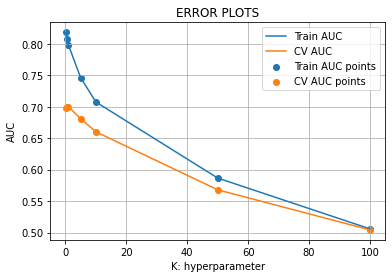

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [0.1,0.5,1,5,10,50,100]
for i in tqdm(K):
    neigh = MultinomialNB(alpha=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

      
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


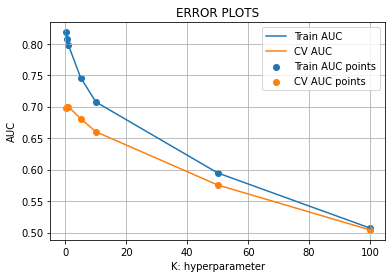

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [0.1,0.5,1,5,10,50,100]
for i in tqdm(K):
    neigh = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

      
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

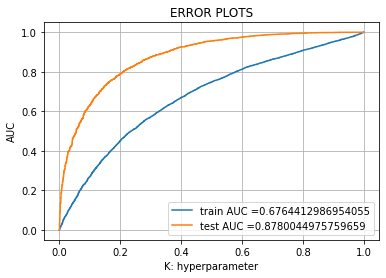

In [70]:
#taking best alpha= 1
from sklearn.metrics import roc_curve, auc

clf=MultinomialNB(alpha=1,class_prior = [0.5, 0.5])
clf.fit(X_te,y_test)
y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test AUC ='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [34]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [35]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4056512399319342 for threshold 0.916
Train confusion matrix
[[ 3308  1817]
 [ 9985 16890]]
Test confusion matrix
[[1380  221]
 [2447 5952]]


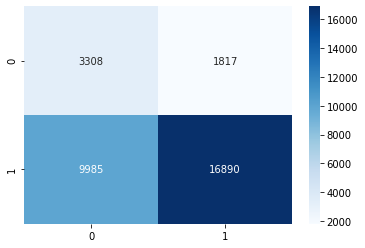

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt     
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True,fmt="d",cmap='Blues')

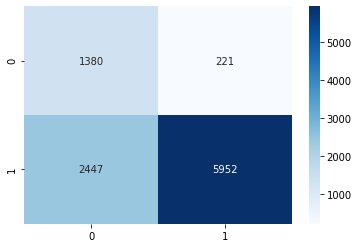

In [37]:
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True,fmt="d",cmap='Blues')

In [38]:
temp=clf.feature_log_prob_[1]

In [39]:
temp

array([-10.9384354 ,  -9.91504653,  -8.5524687 , ...,  -5.90771335,
       -10.09808658, -10.54638651])

In [40]:
temp=np.argsort(temp)

In [41]:
temp

array([ 3634, 10148,  4037, ...,  5992,  7995,  8823])

In [42]:
temp=np.flip(temp)

In [43]:
temp

array([ 8823,  7995,  5992, ...,  4037, 10148,  3634])

In [44]:
len(temp)

10260

In [49]:
len(l)

10260

In [51]:
print("-----------------------Top 20 usefull features-----------------------------------------------------------------------------------")
for ele in range(20):

  print(l[temp[ele]])

-----------------------Top 20 usefull features-----------------------------------------------------------------------------------
students
school
my
classroom
learning
the
not
they
learn
help
many
nannan
reading
need
we
work
use
day
able
love


In [52]:
temp=np.flip(temp)

In [53]:
temp

array([ 3634, 10148,  4037, ...,  5992,  7995,  8823])

In [54]:
print("Top 20  not usefull features")
for ele in range(20):
  print(l[temp[ele]])

Top 20  not usefull features
fillers
wracking
gloomiest
copied
bilateral
upward
manipulated
racket
socials
mins
opportunites
mason
improvising
mirroring
impulses
poetic
internship
prohibits
inactive
terribly


In [61]:
temp=clf.feature_log_prob_[0]
temp=np.argsort(temp)


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


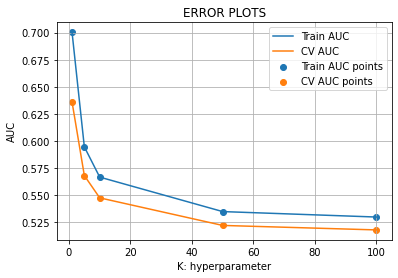

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1,5,10,50,100]
for i in tqdm(K):
    neigh = MultinomialNB(alpha=i,class_prior = [0.5, 0.5])
    neigh.fit(X_tr1, y_train)

    y_train_pred = batch_predict(neigh, X_tr1)    
    y_cv_pred = batch_predict(neigh, X_cr1)

      
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

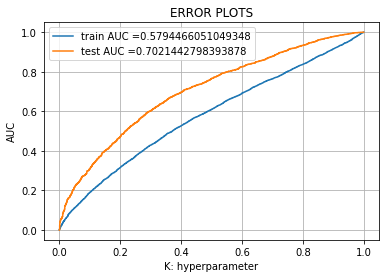

In [71]:
from sklearn.metrics import roc_curve, auc

clf=MultinomialNB(alpha=1,class_prior = [0.5, 0.5])
clf.fit(X_te1,y_test)
y_train_pred = batch_predict(clf, X_tr1)    
y_test_pred = batch_predict(clf, X_te1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [68]:

from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.31684295224049913 for threshold 0.874
Train confusion matrix
[[ 3138  1987]
 [12968 13907]]
Test confusion matrix
[[1158  443]
 [3556 4843]]


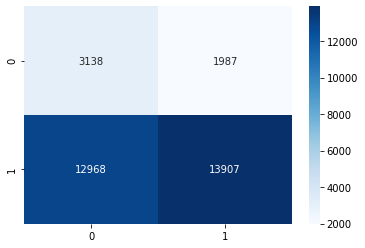

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt     

sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True,fmt="d",cmap='Blues')

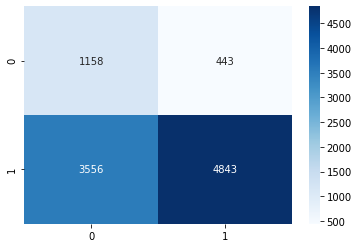

In [67]:
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True,fmt="d",cmap='Blues')

<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [78]:
from tabulate import tabulate
header=['Vectorizier','Model','Hyper Parameter','AUC']
data=[['Bag of words','Multinomial Naive bayes','1','0.87'],['Tfidf','Multinomial Naive Bayes','1','0.702']]
print (tabulate(data, header))

Vectorizier    Model                      Hyper Parameter    AUC
-------------  -----------------------  -----------------  -----
Bag of words   Multinomial Naive bayes                  1  0.87
Tfidf          Multinomial Naive Bayes                  1  0.702
